# **<span style = 'color:blue'>Neural Prophet model for Univariate Time Series Analysis</span>**

## **<span style='color:green'> Table of Contents:</span>**<a id="Table"></a>

* [Import the libraries](#Import)
* [Load the data](#Load)
* [Data Wrangling](#Wrangling)
* [Statistical Data Analysis](#Statistical)
* [Neural Prophet](#Prophet)
    - [Generic Model](#Basic)
    - [Model with seasonality](#seasonality)
    - [Model with AR-Net (AutoRegression)](#lags)
    - [Hyperparameter tuning](#tuning)
* [Final Report](#Report)

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')

## **<span style = 'color:green'>2. Load the dataset</span>**<a name ='Load'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [2]:
weather = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v3/weather.csv')
weather['date'] = pd.to_datetime(weather['date'])
weather.head().style.set_properties(**{'background-color': 'Lavender'})

,date,location_key,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
0,2020-01-01 00:00:00,AD,4.236111,0.138889,8.208333,3.302000,nan,-0.972222,72.773049
1,2020-01-02 00:00:00,AD,3.875000,-0.722222,10.055556,6.688667,nan,-1.625000,70.841314
2,2020-01-03 00:00:00,AD,4.763889,0.597222,8.402778,5.016500,nan,-0.611111,71.117248
3,2020-01-04 00:00:00,AD,4.555556,1.125000,8.708333,3.810000,nan,0.722222,77.338640
4,2020-01-05 00:00:00,AD,4.763889,-1.000000,11.361111,2.476500,nan,-3.361111,60.762380


In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015397 entries, 0 to 20015396
Data columns (total 9 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   location_key                 object        
 2   average_temperature_celsius  float64       
 3   minimum_temperature_celsius  float64       
 4   maximum_temperature_celsius  float64       
 5   rainfall_mm                  float64       
 6   snowfall_mm                  float64       
 7   dew_point                    float64       
 8   relative_humidity            float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.3+ GB


## **<span style = 'color:green'>3. Data Wrangling</span>**<a name ='Wrangling'></a> 
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 
### **<span style = 'color:orange'>Checking for Missing Values</span>**
For easy computation & simple demonstration purposes, I have chosen the time series for 'NO' location key.

In [4]:
weather = weather[weather['location_key']=='NO']
print(weather.shape)

weather[weather.columns[weather.isnull().sum()>0]].isnull().sum()

(909, 9)


snowfall_mm    711
dtype: int64

In [5]:
weather['snowfall_mm'] = weather['snowfall_mm'].fillna(0)
weather[weather.columns[weather.isnull().sum()>0]].isnull().sum()

Series([], dtype: float64)

## **<span style='color:green'>4. Statistical Data Analysis</span>**<a name ='Statistical'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 

In [6]:
weather.describe()

,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
count,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,5.520244,2.450323,8.298812,1.489358,88.872989,1.629074,77.388934
std,6.612908,6.213048,7.232403,3.027568,234.501259,6.218192,9.751408
min,-12.697531,-16.117284,-10.135802,0.000000,0.000000,-16.030864,42.012927
25%,1.298611,-1.539683,3.802469,0.000000,0.000000,-2.580247,71.710868
50%,4.733333,1.988889,6.923611,0.381000,0.000000,1.419753,79.042910
75%,10.438889,7.388889,13.358025,1.693333,0.000000,6.444444,84.402213
max,23.444444,17.877778,28.544444,50.038000,1501.140000,14.962963,96.444783


### **<span style = 'color:orange'>Data Summary with Tableone</span>**

In [7]:
pip install tableone --quiet

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import tableone
from tableone import TableOne, load_dataset

# Create a simple Table 1 with no grouping variable
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
#Create an instance of TableOne with the input arguments:
table1 = TableOne(weather, dip_test=True, normal_test=True, tukey_test=True)
# View table1 (note the remarks below the table)
table1

,,Missing,Overall
n,,,909
"date, mean (SD)",,0,1617157829702970368.0 (22758409631452576.0)
"location_key, n (%)",NO,0,909 (100.0)
"average_temperature_celsius, mean (SD)",,0,5.5 (6.6)
"minimum_temperature_celsius, mean (SD)",,0,2.5 (6.2)
"maximum_temperature_celsius, mean (SD)",,0,8.3 (7.2)
"rainfall_mm, mean (SD)",,0,1.5 (3.0)
"snowfall_mm, mean (SD)",,0,88.9 (234.5)
"dew_point, mean (SD)",,0,1.6 (6.2)
"relative_humidity, mean (SD)",,0,77.4 (9.8)


#### **<span style = 'color:orange'>Exploring the warning raised by Hartigan's Dip Test</span>**
Hartigan's Dip Test is a test for multimodality. The test has suggested that the average_temperature_celsius and maximum_temperature_celsius may be multimodal. A distribution with one peak is called unimodal A distribution with two peaks is called bimodal A distribution with two peaks or more is multimodal A bimodal distribution is also multimodal, as there are multiple peaks. We'll plot the distributions here.

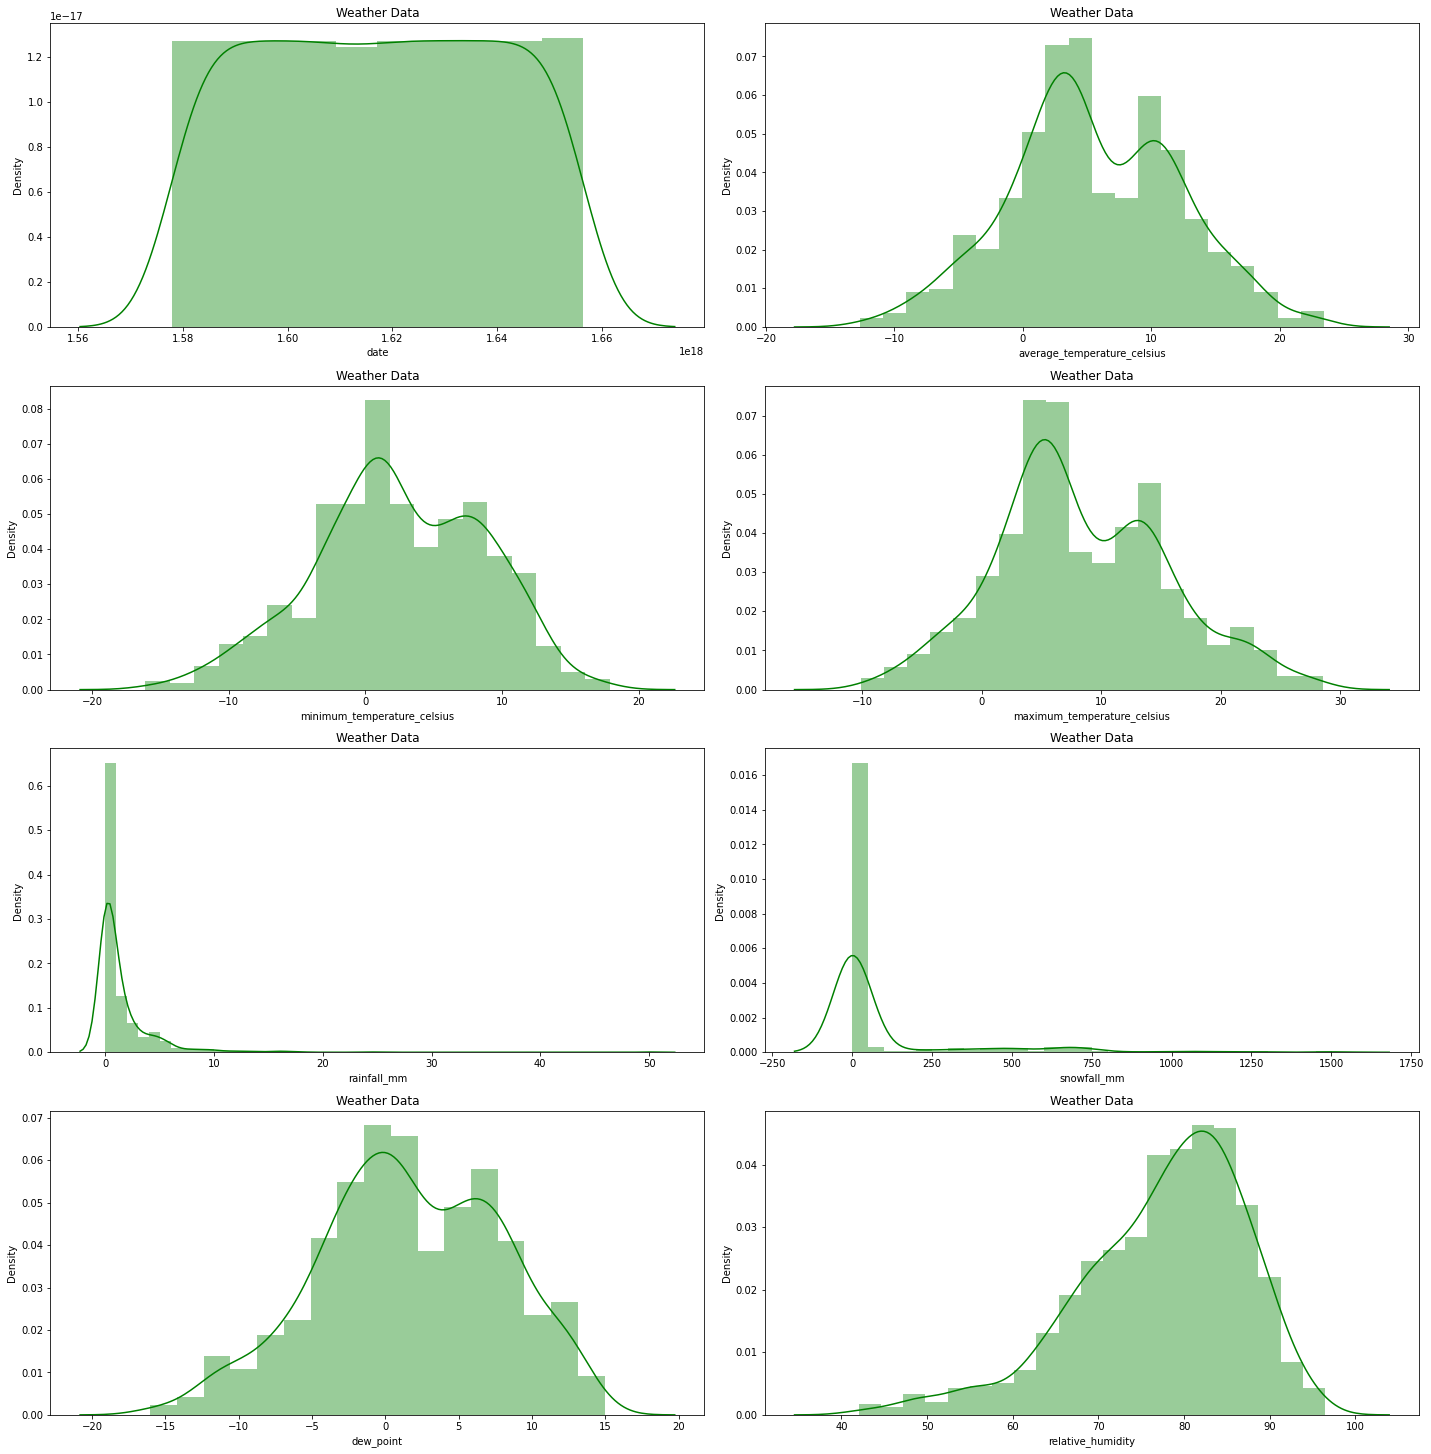

In [9]:
# Numerical features
num_feats=[col for col in weather.columns if weather[col].dtypes != 'object' and col != 'Id']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(20,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    sb.distplot(weather[col], color ='green')
    plt.title(f'Weather Data')


    
fig.tight_layout()
plt.show()

#### **<span style = 'color:orange'>Exploring the warning raised by Tukey's rule</span>**
Tukey's rule has found far outliers in rainfall, so we'll look at this in a boxplot

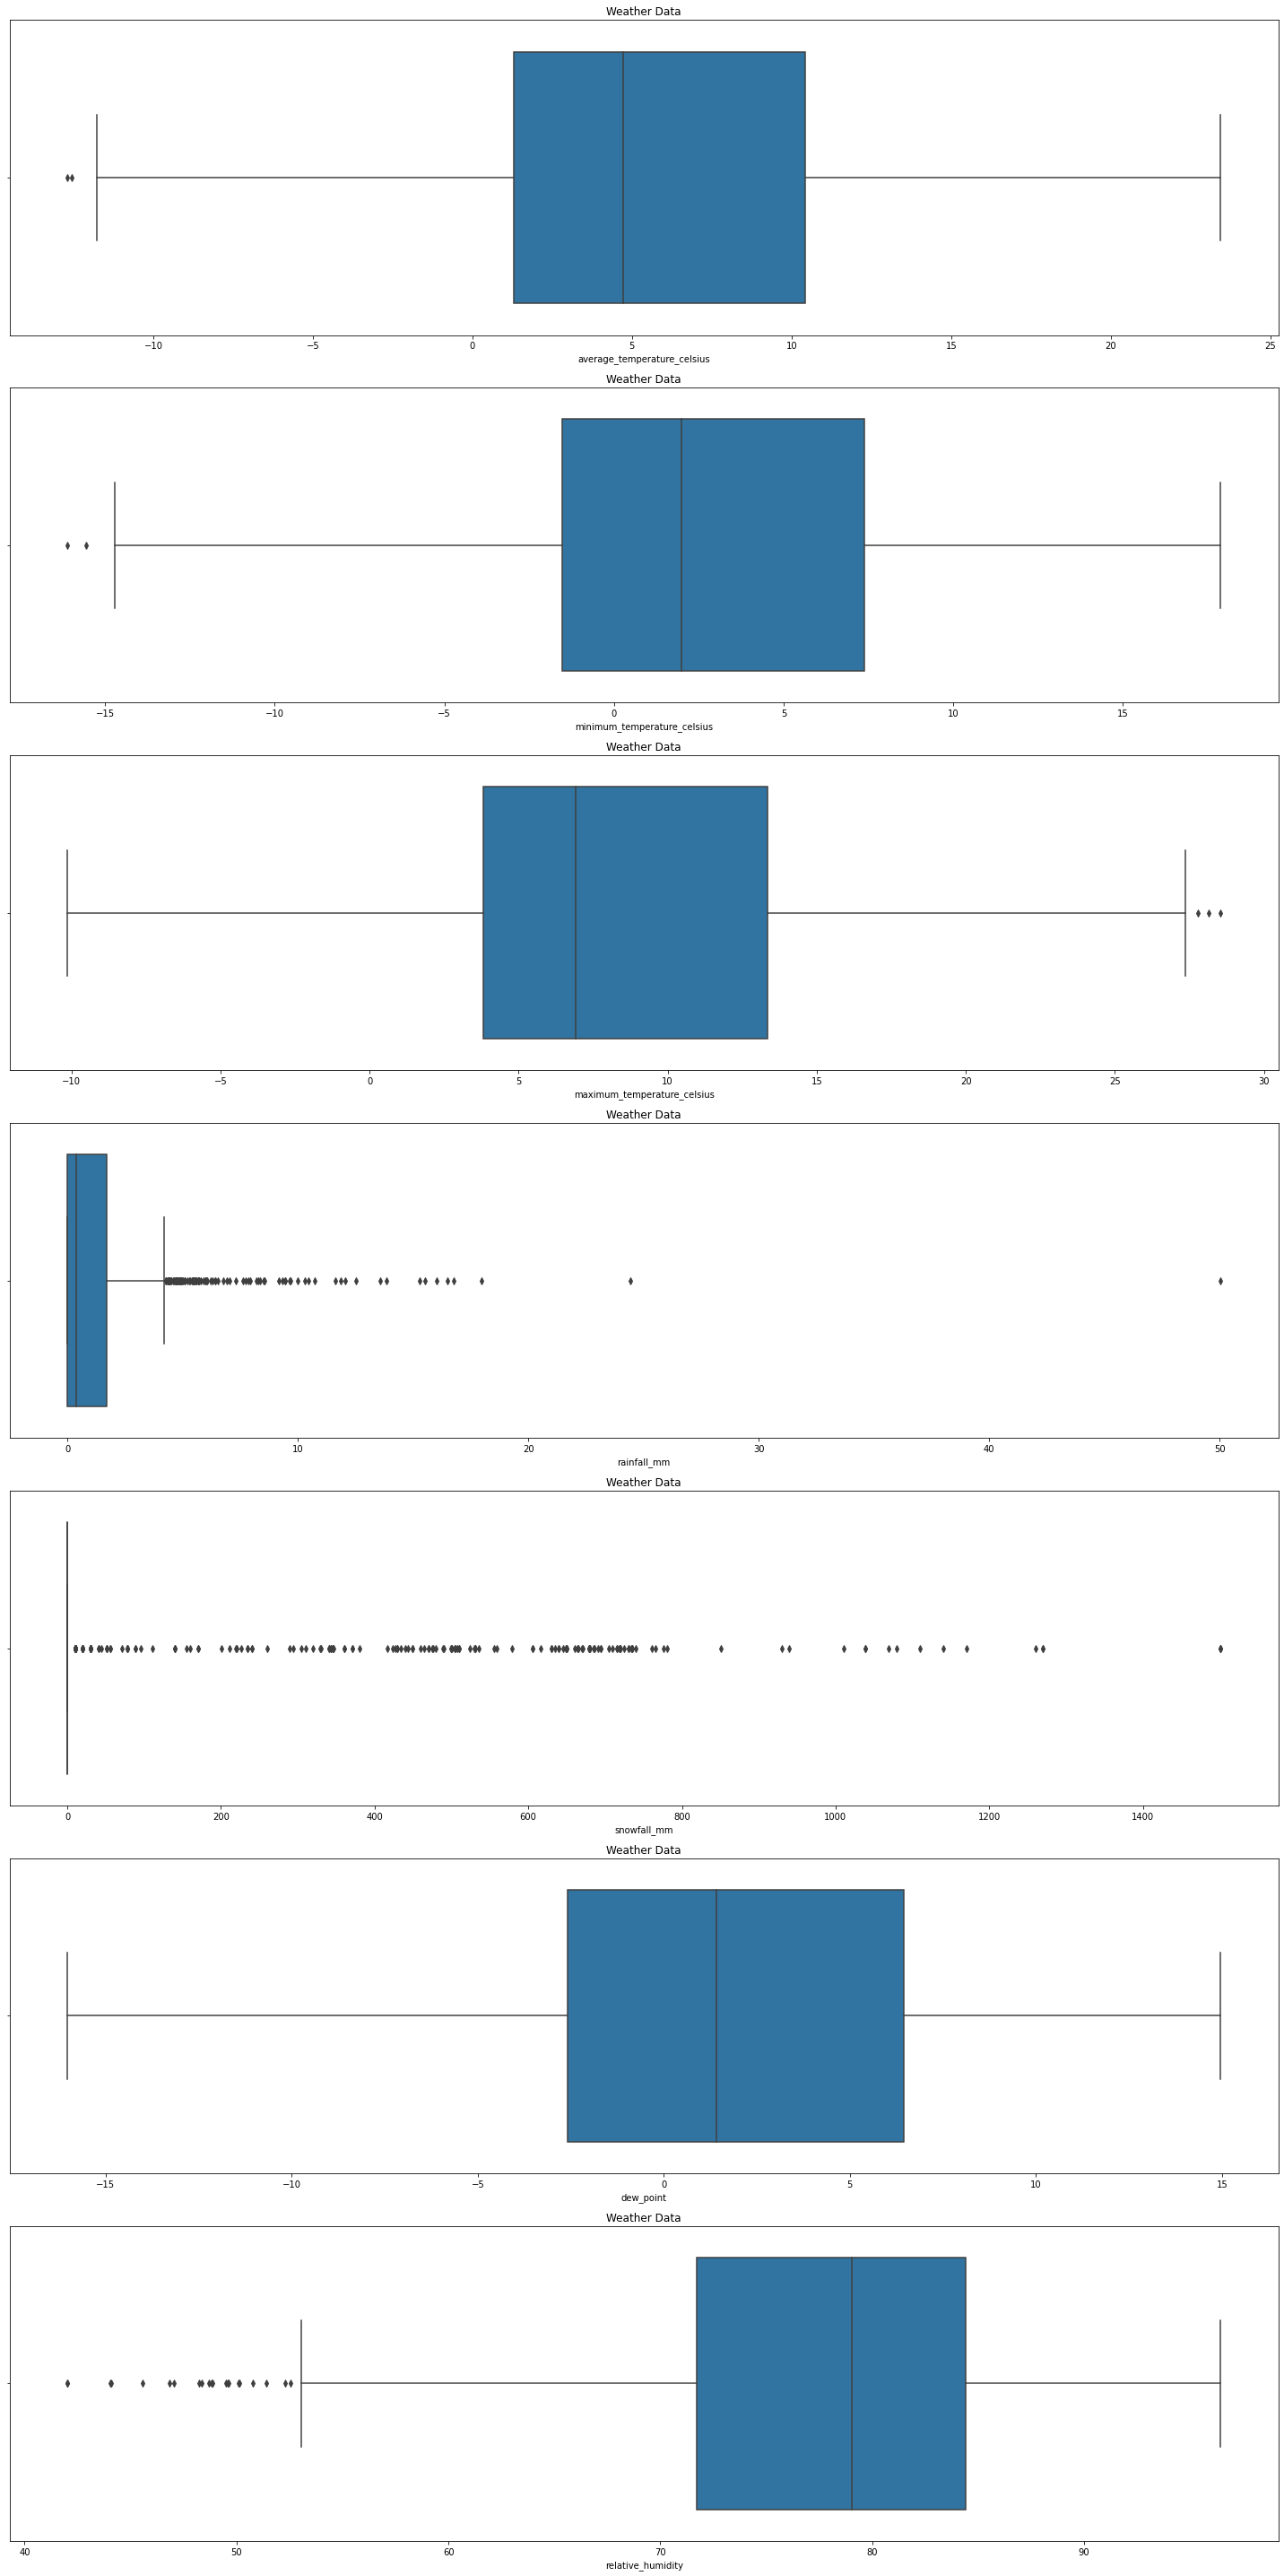

In [10]:
# Numerical features
num_feats=[col for col in weather.columns if weather[col].dtypes != 'object' and col != 'date']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(20,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),1,1*i+1)
    sb.boxplot(weather[col])
    plt.title(f'Weather Data')
    
fig.tight_layout()
plt.show()

In [11]:
df_trans = weather.copy()
df_trans['rainfall_mm'] = weather['rainfall_mm']**0.5  # right outlier data -> apply square root transform

After trying both log and square root combinations the best results are obtained for using latter. Its better to remove snaowfall_mm as it contains a lot of outliers. 

Plotting them to visualize before and after transformation effects.  

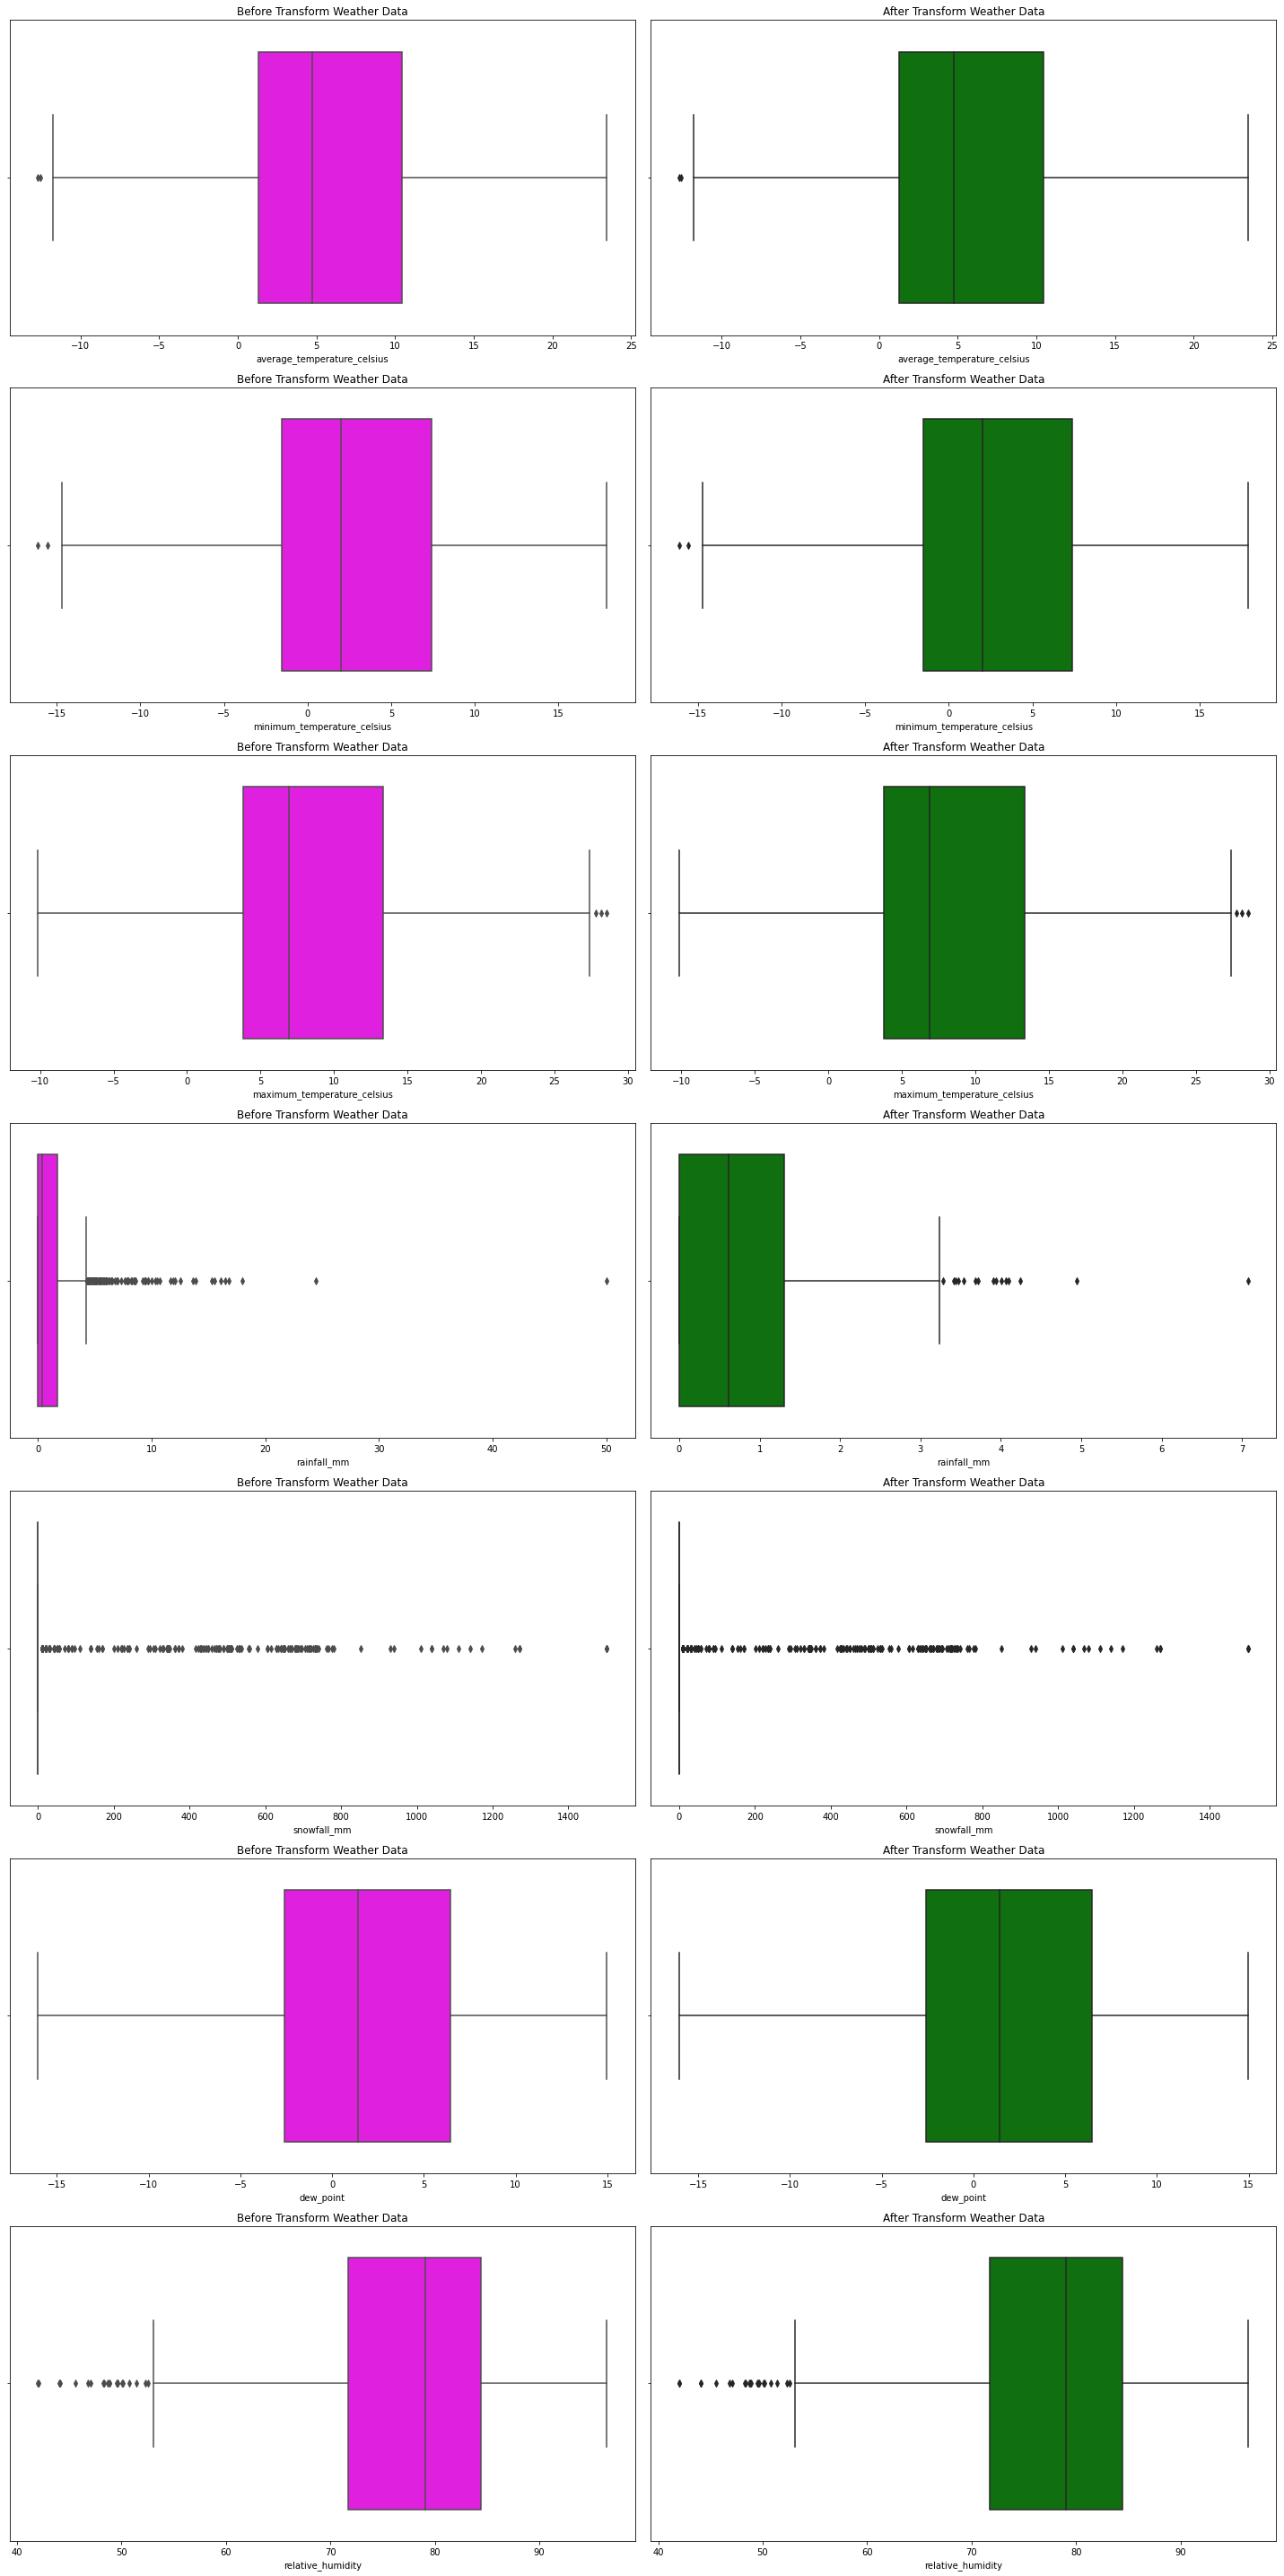

In [12]:
# Numerical features
num_feats=[col for col in weather.columns if weather[col].dtypes != 'object' and col != 'date']

# Plot distribution of numerical columns
fig=plt.figure(figsize=(20,40))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,2*i+1)
    sb.boxplot(weather[col], color = 'magenta')
    plt.title(f'Before Transform Weather Data')

for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,2*i+2)
    sb.boxplot(df_trans[col], color = 'green')
    plt.title(f'After Transform Weather Data')
    
fig.tight_layout()
plt.show()

weather['rainfall_mm'] = df_trans['rainfall_mm']

### **<span style = 'color:orange'>Shapiro-Wilk test for normality</span>**
The Shapiro-Wilk test is a test of normality. It is used to determine whether or not a sample comes from a normal distribution.

In [13]:
#perform Shapiro-Wilk test for normality
from scipy.stats import shapiro
shapiro(weather['average_temperature_celsius'])

ShapiroResult(statistic=0.9948248267173767, pvalue=0.0034286545123904943)

Since the p-value is less than .05, the null hypothesis of normality is to be rejected. We do have sufficient evidence to say that the sample data does not come from a normal distribution. 

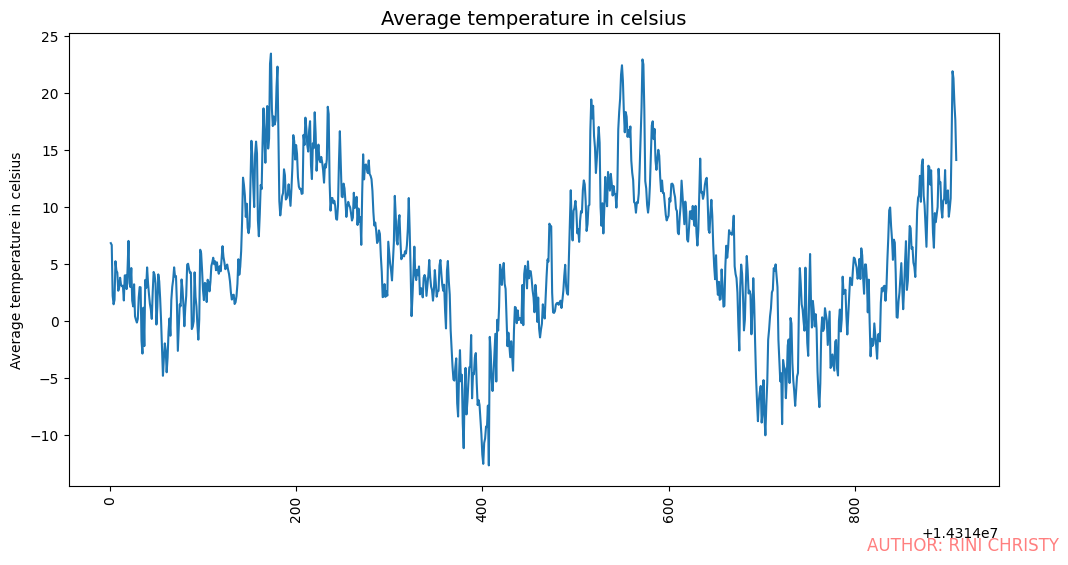

In [14]:
# Plotting by Pandas method, drawing axes by Matplotlib
def display_plot(df, fig_title):
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.title(fig_title, fontsize=14)
    f.text(0.95, 0.01, 'AUTHOR: RINI CHRISTY',
         fontsize=12, color='red',
         ha='right', va='bottom', alpha=0.5);
    df.plot(ax=ax,rot=90, ylabel='Average temperature in celsius');

# Plot the Energy Consumption data
display_plot(weather['average_temperature_celsius'], 'Average temperature in celsius')

## **<span style = 'color:green'>5. Neural Prophet for univariate analysis**<a name ='Prophet'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 
### **<span  style ='color: orange'> Generic model</span>**<a id ='Basic'></a>

In [15]:
df = weather.copy()
df = df[['date','average_temperature_celsius']]
df.columns = ['ds', 'y'] 
df.head()

,ds,y
14314001,2020-01-01,6.808642
14314002,2020-01-02,6.648148
14314003,2020-01-03,2.185185
14314004,2020-01-04,1.444444
14314005,2020-01-05,1.833333


In [16]:
pip install neuralprophet[live]  --quiet

Note: you may need to restart the kernel to use updated packages.


NeuralProphet has a number of hyperparameters that need to be specified by the user. If not specified, default values for these hyperparameters will be used. 

If it looks like the model is overfitting to the training data (the live loss plot can be useful hereby), you can reduce epochs and learning_rate, and potentially increase the batch_size. If it is underfitting, the number of epochs and learning_rate can be increased and the batch_size potentially decreased.

The default loss function is the ‘Huber’ loss, which is considered to be robust to outliers. However, the standard MSE or any other PyTorch torch.nn.modules.loss loss function also can be chosen.

NeuralProphet offers to set two different values for optimizer, namely AdamW and SDG (stochastic gradient decsent), AdamW being the default.

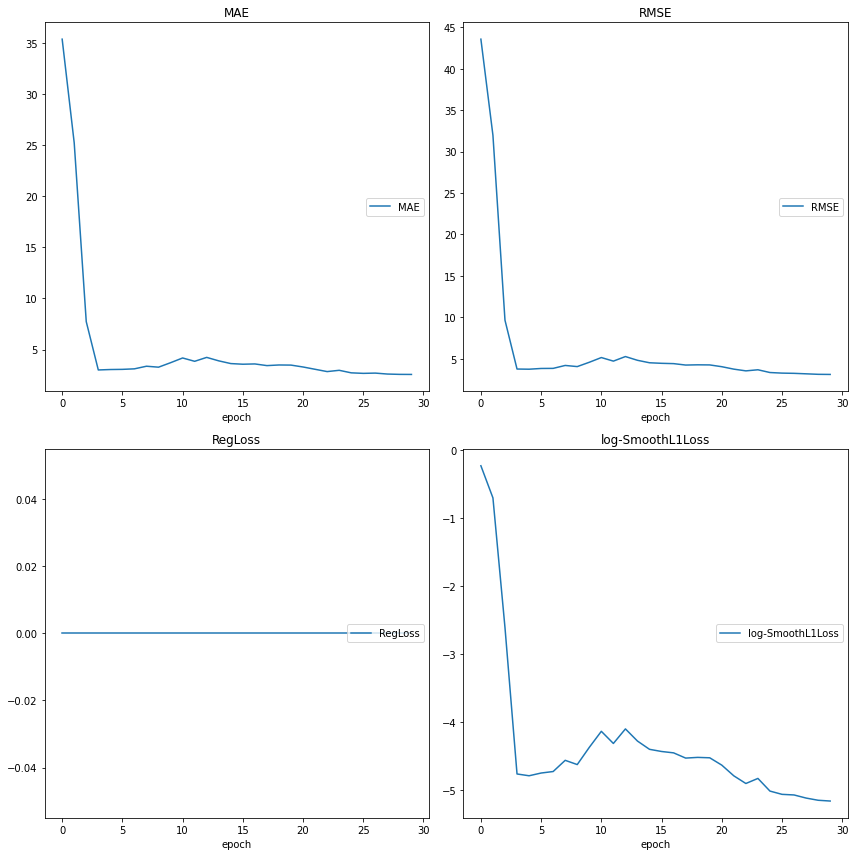

MAE
	MAE              	 (min:    2.564, max:   35.377, cur:    2.564)
RMSE
	RMSE             	 (min:    3.105, max:   43.577, cur:    3.105)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.156, max:   -0.230, cur:   -5.156)


,SmoothL1Loss,MAE,RMSE,RegLoss
29,0.005763,2.564278,3.105454,0.0


In [17]:
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
m = NeuralProphet(epochs = 30)
model = m.fit(df, freq= 'd', progress= 'plot-all')
model[-1:]

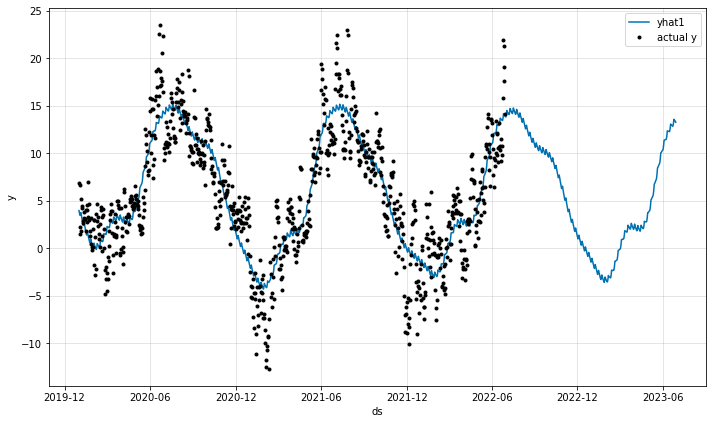

In [18]:
future = m.make_future_dataframe(df=df, periods=365, n_historic_predictions=True)
forecast = m.predict(df=future)
fig_forecast = m.plot(forecast)

In [19]:
df

,ds,y
14314001,2020-01-01,6.808642
14314002,2020-01-02,6.648148
14314003,2020-01-03,2.185185
14314004,2020-01-04,1.444444
14314005,2020-01-05,1.833333
...,...,...
14314905,2022-06-25,21.895062
14314906,2022-06-26,21.277778
14314907,2022-06-27,19.105556
14314908,2022-06-28,17.605556


In [20]:
future

,ds,y
0,2020-01-01,6.808642
1,2020-01-02,6.648148
2,2020-01-03,2.185185
3,2020-01-04,1.444444
4,2020-01-05,1.833333
...,...,...
1269,2023-06-25,NaN
1270,2023-06-26,NaN
1271,2023-06-27,NaN
1272,2023-06-28,NaN


In [21]:
print(list(forecast.columns))

['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly', 'season_weekly']


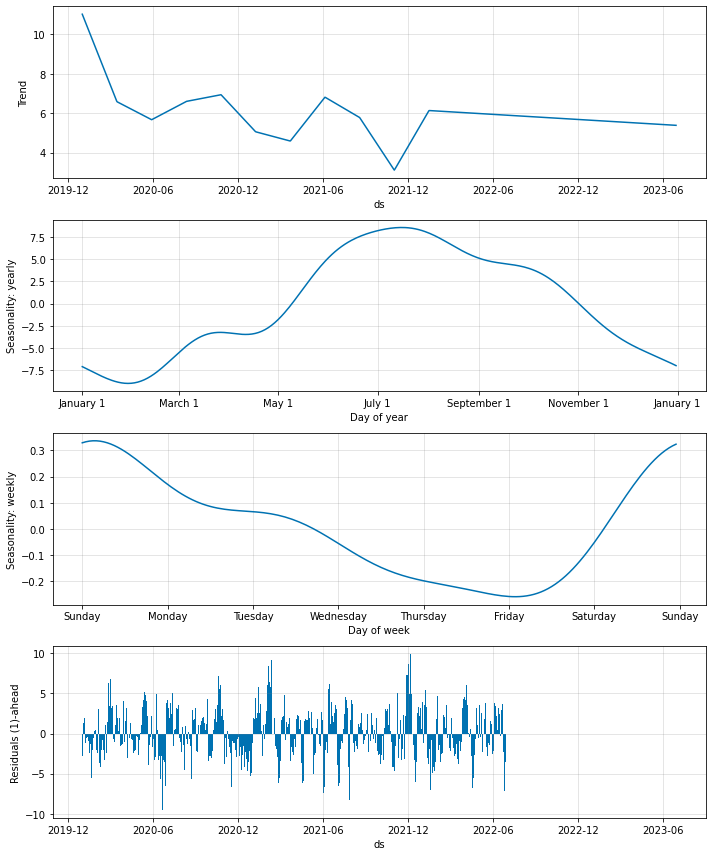

In [22]:
# plots the individual forecast components for the given time period.
fig = m.plot_components(forecast, residuals=True)

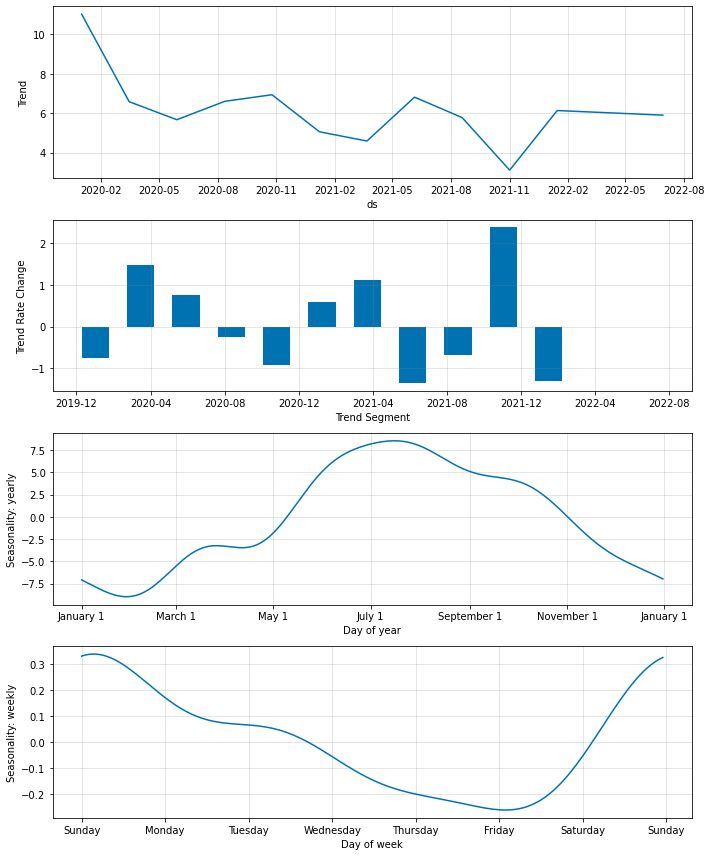

In [23]:
# visualizes the model parameters.
fig2 = m.plot_parameters()

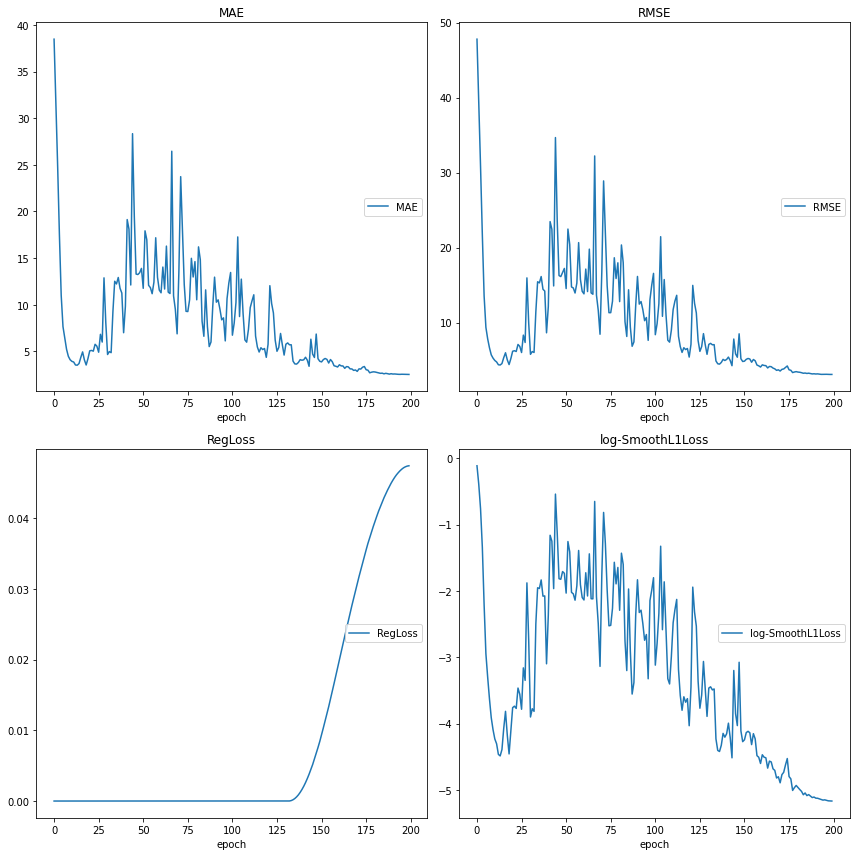

MAE
	MAE              	 (min:    2.523, max:   38.476, cur:    2.523)
RMSE
	RMSE             	 (min:    3.087, max:   47.785, cur:    3.087)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.047, cur:    0.047)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.170, max:   -0.112, cur:   -5.170)


In [24]:
m = NeuralProphet(
    n_changepoints=30,
    changepoints_range=0.90,
    trend_reg=1
)
metrics = m.fit(df, freq="D", progress= 'plot-all')
forecast = m.predict(df)

#### **<span  style ='color: brown'> Generic model with train & validation sets</span>**

The dataset contains around 3 years of daily observations. The training will occur on 9/10th of the data, reserving the last 1/10th for evaluation.

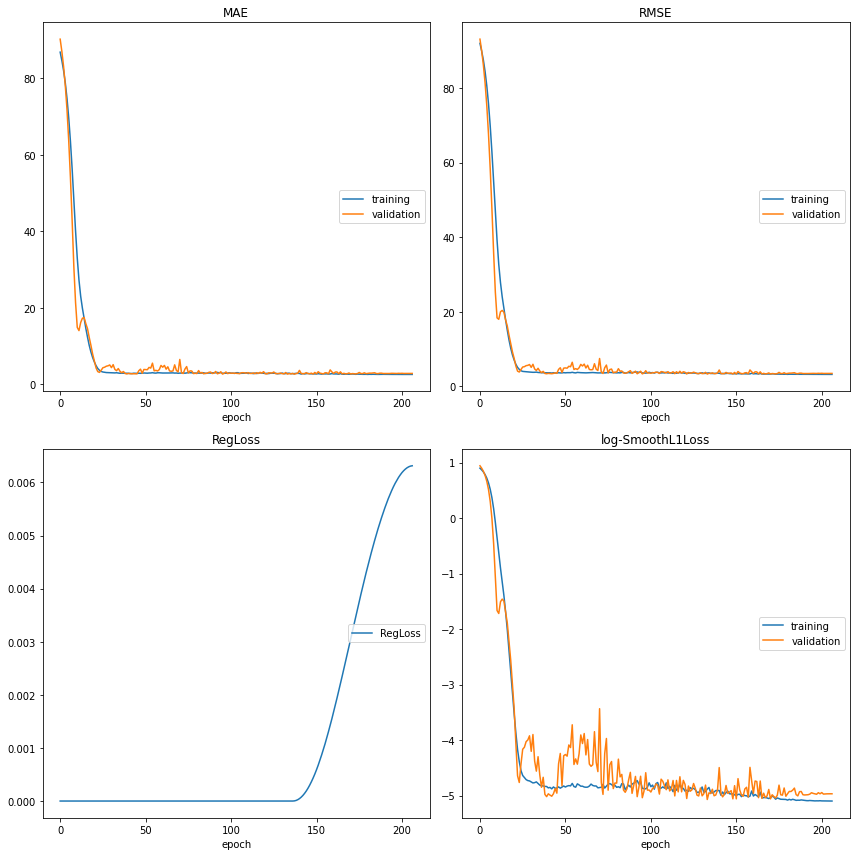

MAE
	training         	 (min:    2.622, max:   86.806, cur:    2.622)
	validation       	 (min:    2.683, max:   90.198, cur:    2.885)
RMSE
	training         	 (min:    3.197, max:   91.971, cur:    3.206)
	validation       	 (min:    3.296, max:   93.093, cur:    3.470)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.006, cur:    0.006)
log-SmoothL1Loss
	training         	 (min:   -5.097, max:    0.900, cur:   -5.097)
	validation       	 (min:   -5.069, max:    0.943, cur:   -4.966)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
202,0.006121,2.623344,3.196679,0.006253,0.006950,2.881418,3.465298
203,0.006117,2.622320,3.210045,0.006277,0.006963,2.884240,3.468459
204,0.006117,2.621800,3.203811,0.006296,0.006972,2.885994,3.470627
205,0.006116,2.621723,3.207362,0.006309,0.006969,2.885439,3.470016
206,0.006115,2.621656,3.206028,0.006315,0.006968,2.885315,3.469857


In [25]:
m = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
)
df_train, df_val = m.split_df(df, freq='D', valid_p = 1.0/10)

metrics = m.fit(df_train, freq='d', validation_df=df_val, progress='plot-all')
metrics.tail()

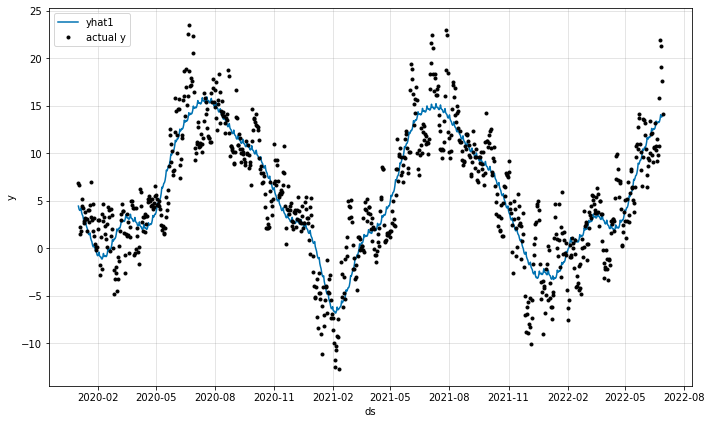

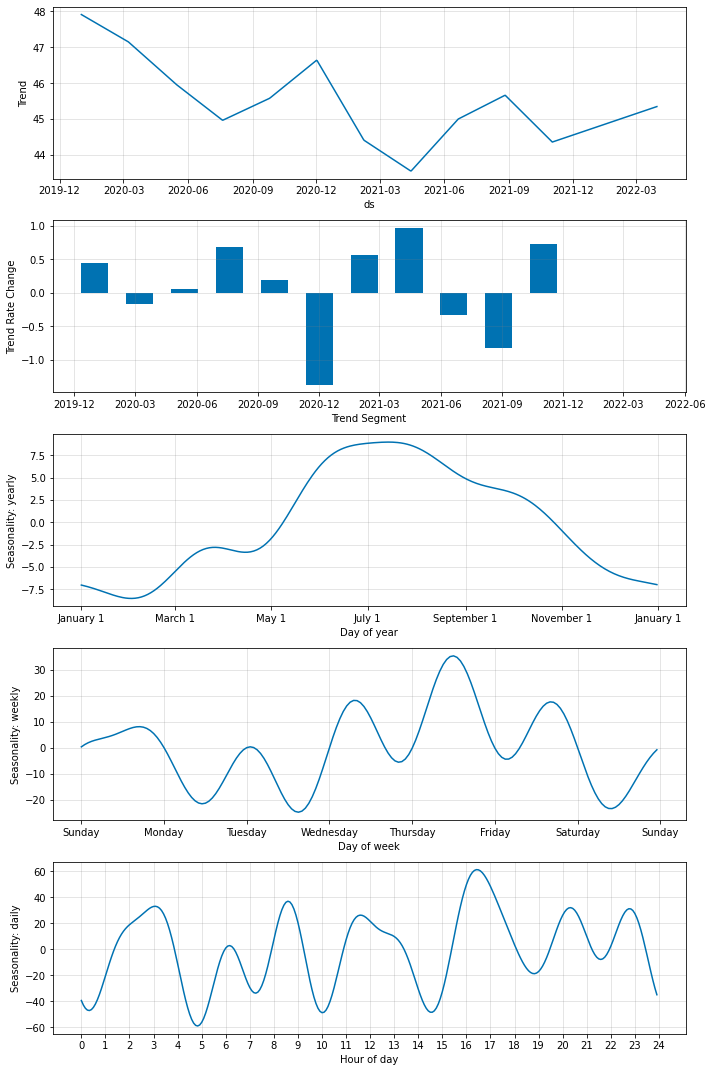

In [26]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()

### **<span  style ='color: orange'> Model with seasonality</span>**<a id ="seasonality"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 
Looking at the yearly seasonality in the second last plot it can be seen that average temperature is at its lowest in February and lower in all winter months, and higher in summer months with July being the hottest month. Both the weekly and yearly seasonal shapes in the above plots. Since required seasonality is not explicitly stated in the model development, NeuralProphet fits any seasonality that is possible with the data. The model also assigns default values to the number of Fourier terms desired for every seasonality. 

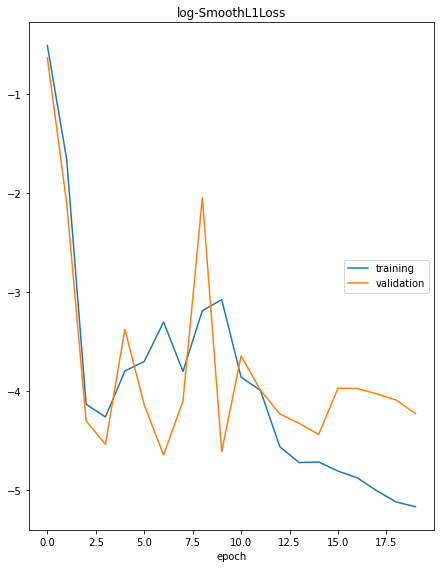

log-SmoothL1Loss
	training         	 (min:   -5.168, max:   -0.509, cur:   -5.168)
	validation       	 (min:   -4.645, max:   -0.634, cur:   -4.227)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
19,0.005696,2.54389,3.086297,0.0,0.014592,4.196533,5.021186


In [27]:
m = NeuralProphet(epochs = 20, daily_seasonality = True, yearly_seasonality = True)
model = m.fit(df_train, freq= 'd', validation_df= df_val, progress= 'plot')
model.tail(1)

By playing around with the number of Fourier terms, the seasonality can be either underfit or overfit .  Keeping weekly seasonality as default 'auto',  specify seasonality to daily and yearly as in the below code.

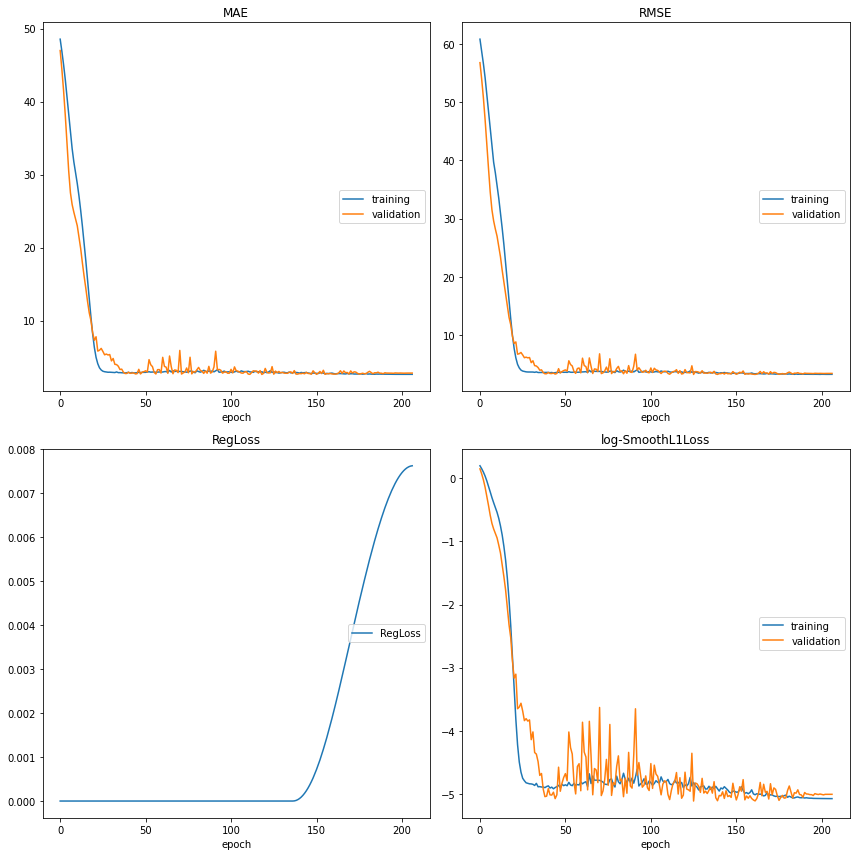

MAE
	training         	 (min:    2.653, max:   48.542, cur:    2.653)
	validation       	 (min:    2.640, max:   46.987, cur:    2.825)
RMSE
	training         	 (min:    3.236, max:   60.829, cur:    3.245)
	validation       	 (min:    3.226, max:   56.793, cur:    3.403)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.008, cur:    0.008)
log-SmoothL1Loss
	training         	 (min:   -5.074, max:    0.198, cur:   -5.074)
	validation       	 (min:   -5.112, max:    0.149, cur:   -5.006)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
202,0.006260,2.654122,3.250217,0.007550,0.006698,2.823589,3.401758
203,0.006260,2.653457,3.239764,0.007580,0.006695,2.823286,3.401208
204,0.006260,2.653699,3.243035,0.007603,0.006705,2.825785,3.403648
205,0.006258,2.653231,3.240864,0.007618,0.006702,2.824984,3.402783
206,0.006258,2.653212,3.244638,0.007626,0.006701,2.824723,3.402536


In [28]:
m = NeuralProphet(
    yearly_seasonality=6,
    daily_seasonality=12,
    trend_reg=1,
    learning_rate=0.01,
)
df_train, df_val = m.split_df(df, freq='D', valid_p = 1.0/10)

metrics = m.fit(df_train, freq='d', validation_df=df_val, progress='plot-all')
metrics.tail()

RMSE_val has improved a lot by manually filling seasonality values.

### **<span  style ='color: orange'> Model with AR-Net (AutoRegression)</span>**<a id="lags"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 

AR-Net can be enabled in the NeuralProphet by simply setting an appropriate value to the n_lags parameter of the NeuralProphet object. n_lags defines whether the AR-Net is enabled (if n_lags > 0) or not. The value for n_lags is usually recommended to be greater than n_forecasts, n_lags determine how far into the past the auto-regressive dependencies should be considered. This could be a value chosen based on either domain expertise or an empirical analysis.

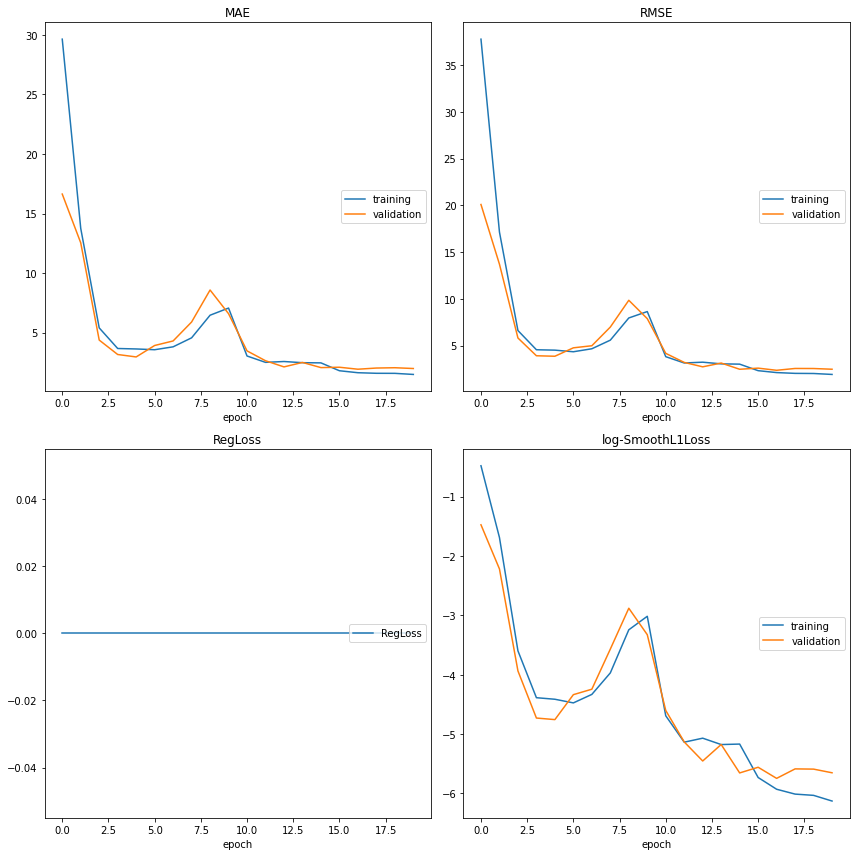

MAE
	training         	 (min:    1.491, max:   29.641, cur:    1.491)
	validation       	 (min:    1.930, max:   16.635, cur:    1.989)
RMSE
	training         	 (min:    1.903, max:   37.782, cur:    1.903)
	validation       	 (min:    2.347, max:   20.089, cur:    2.460)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -6.128, max:   -0.480, cur:   -6.128)
	validation       	 (min:   -5.746, max:   -1.474, cur:   -5.652)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
15,0.003243,1.801648,2.306200,0.0,0.003854,2.095471,2.577635
16,0.002661,1.635741,2.102166,0.0,0.003196,1.930049,2.347225
17,0.002452,1.587347,2.017859,0.0,0.003749,2.028308,2.542282
18,0.002401,1.582926,2.004594,0.0,0.003735,2.054375,2.537476
19,0.002182,1.491403,1.903445,0.0,0.003512,1.988683,2.460306


In [29]:
m = NeuralProphet(epochs = 20, daily_seasonality = True, yearly_seasonality = True, n_lags=3)
model = m.fit(df_train, freq= 'd', validation_df= df_val, progress= 'plot-all')
model.tail()

In the above example, forecasting scenario, which feeds 3 lags into AR-Net is created. n_forecasts can also be given as forecasts. n_forecasts is the size of the forecast horizon. The default value of 1 means that the model forecasts one step into the future. Once the AR-Net is enabled, during forecasting the future_periods value should be equal to the n_forecasts value specified when creating the NeuralProphet object. Whichever value is specified for future_periods, it will be converted to the value of n_forecasts with a notice to the user. This is because, since the AR-Net is built during training such that it has an ouptut size of n_forecasts, it cannot support any other value during testing.

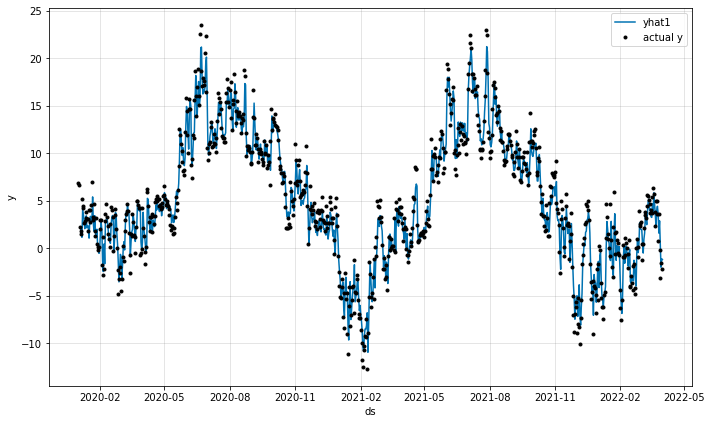

In [30]:
future = m.make_future_dataframe(df=df_train, periods=365, n_historic_predictions=True)
forecast = m.predict(df=future)
fig_forecast = m.plot(forecast)

Generate the plots of the components for detailed analysis -

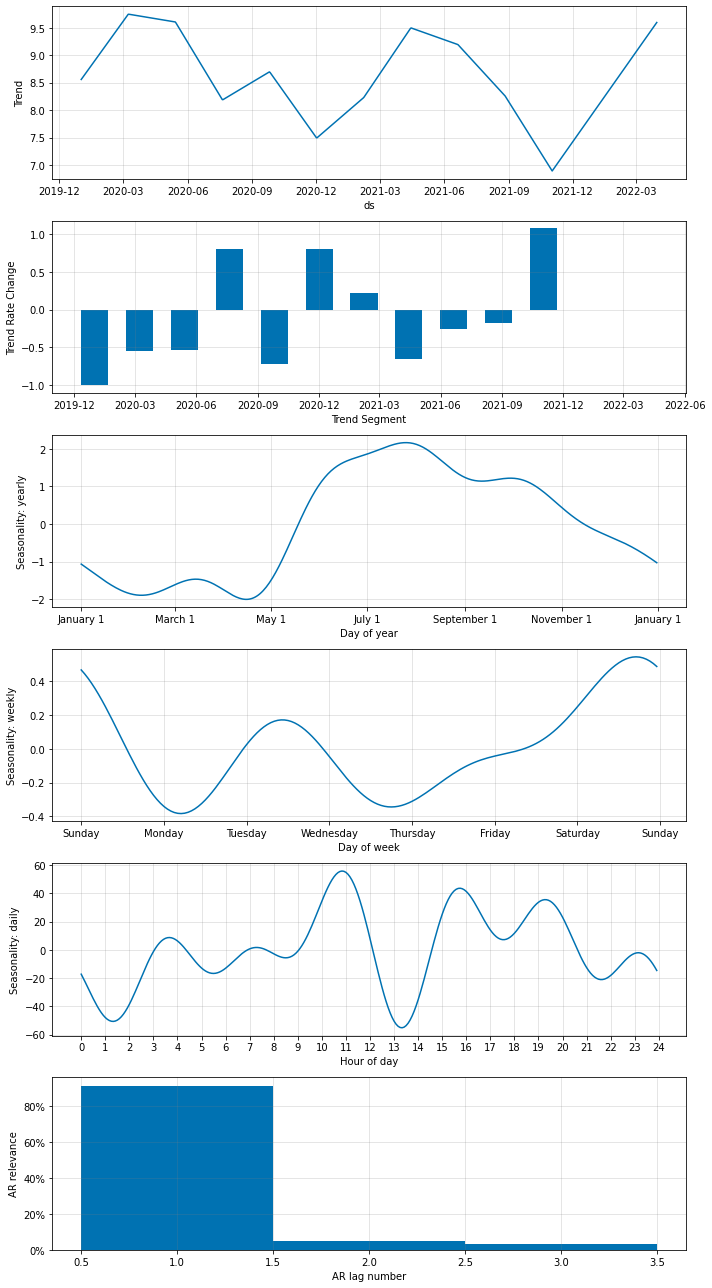

In [31]:
fig_param = m.plot_parameters()

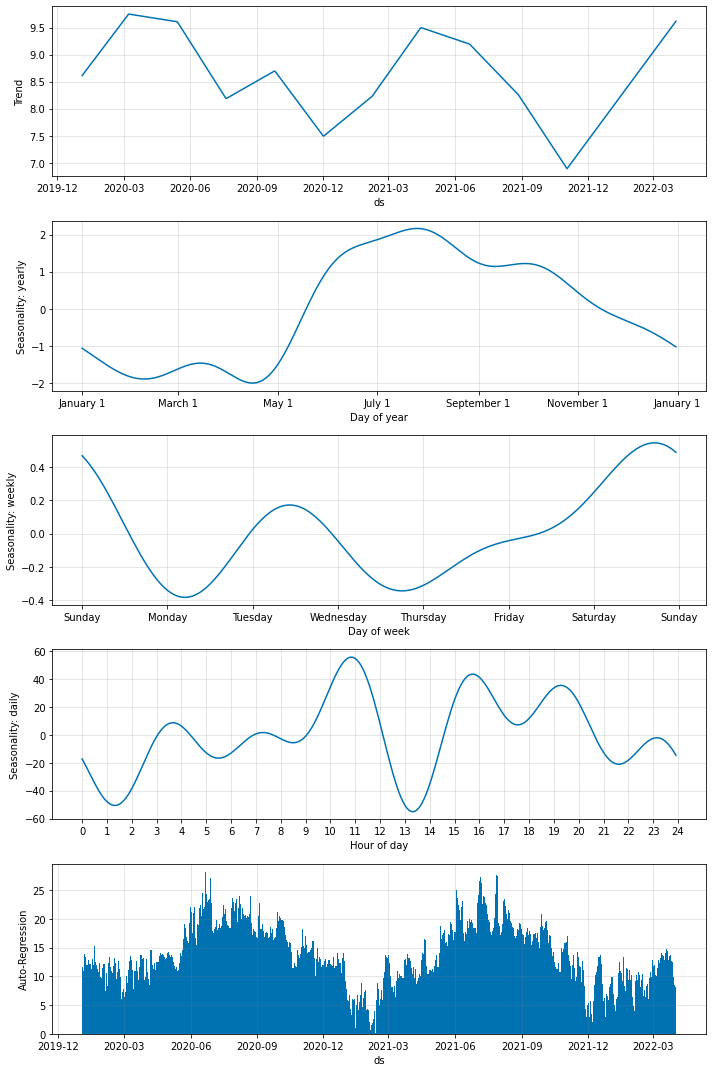

In [32]:
plt2 = m.plot_components(forecast)


### **<span  style ='color: orange'> Hyperparameter tuning</span>**<a id="tuning"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 

NeuralProphet has a number of hyperparameters that need to be specified by the user. If not specified, default values for these hyperparameters will be used. They are as follows.

<p  style ='color: purple; font-family: Arial'>class neuralprophet.forecaster.NeuralProphet(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.9, trend_reg=0, trend_reg_threshold=False, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive', seasonality_reg=0, n_forecasts=1, n_lags=0, num_hidden_layers=0, d_hidden=None, ar_reg=None, learning_rate=None, epochs=None, batch_size=None, loss_func='Huber', optimizer='AdamW', newer_samples_weight=2, newer_samples_start=0.0, impute_missing=True, collect_metrics=True, normalize='auto', global_normalization=False, global_time_normalization=True, unknown_data_normalization=False)</p>

Creating a parameter grid and then training models using all the possible parameter combinations ensure that the model is not overfitting to the validation set. The training RMSE score and epoch where when the validation score was at its lowest are selected to repeat the steps further to search for other combinations of parameters.

#### **<span  style ='color: brown'> Trend Related Parameters</span>**

The trend flexibility is primarily controlled by *n_changepoints*, which sets the number of points where the trend rate may change. Additionally, the trend rate changes can be regularized by setting trend_reg to a value greater zero.
This is a useful feature that can be used to automatically detect relevant changepoints.

*changepoints_range* controls the range of training data used to fit the trend. The default value of 0.8 means that no changepoints are set in the last 20 percent of training data. *n_changepoints* is the number of changepoints selected along the series for the trend. The default value for this is 5.

In [33]:
import itertools
# Parameter Options
param_grid = {  
    'trend_reg': [1,2,3,4,5,6],
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, n_lags=3, learning_rate=0.02, epochs=50, batch_size=32)
    m.add_country_holidays(country_name='Norway')
    metrics4 = m.fit(df=df_train, validation_df=df_val, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

results

[{'RMSE_val': 3.307626485824585,
  'RMSE_train': 4.025164284741091,
  'score_epoch_number': 15,
  'trend_reg': 1,
  'changepoints_range': 0.95},
 {'RMSE_val': 4.29003381729126,
  'RMSE_train': 4.973557774187009,
  'score_epoch_number': 18,
  'trend_reg': 1,
  'changepoints_range': 0.975},
 {'RMSE_val': 7.771395683288574,
  'RMSE_train': 8.335185008993358,
  'score_epoch_number': 13,
  'trend_reg': 1,
  'changepoints_range': 0.99},
 {'RMSE_val': 2.4632160663604736,
  'RMSE_train': 2.213196358062819,
  'score_epoch_number': 45,
  'trend_reg': 1,
  'changepoints_range': 0.995},
 {'RMSE_val': 4.082607269287109,
  'RMSE_train': 4.170688521891177,
  'score_epoch_number': 18,
  'trend_reg': 1,
  'changepoints_range': 0.999},
 {'RMSE_val': 8.0956449508667,
  'RMSE_train': 7.221239175073675,
  'score_epoch_number': 15,
  'trend_reg': 2,
  'changepoints_range': 0.95},
 {'RMSE_val': 4.3252129554748535,
  'RMSE_train': 4.169554788500872,
  'score_epoch_number': 47,
  'trend_reg': 2,
  'changepoint

In [34]:
# Find the best parameters
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df = results_df.sort_values('RMSE_val')
results_df.head(10)

,RMSE_val,RMSE_train,score_epoch_number,trend_reg,changepoints_range
19,2.067781,2.104697,41,4,0.999
15,2.148895,2.299530,31,4,0.950
17,2.225089,2.888938,22,4,0.990
24,2.291778,2.620528,34,5,0.999
3,2.463216,2.213196,45,1,0.995
16,2.547406,3.331984,29,4,0.975
10,2.581070,2.271231,44,3,0.950
7,2.609171,2.574210,26,2,0.990
23,2.686559,3.278693,39,5,0.995
14,2.714828,2.924356,42,3,0.999


#### **<span  style ='color: brown'> Depth of the Model</span>**

The parameter *num_hidden_layers* defines the number of hidden layers of the Feed Forward Neural Networks (FFNNs) used in the overall model. This includes the AR-Net and the FFNN of the lagged regressors. The default is 0, meaning that the FFNNs will have only one final layer of size n_forecasts. Adding more layers results in increased complexity and also increased computational time, consequently. However, the added number of hidden layers can help build more complex relationships especially useful for the lagged regressors. To tradeoff between the computational complexity and the improved accuracy the num_hidden_layers is recommended to be set in between 1-2. Nevertheless, in most cases a good enough performance can be achieved by having no hidden layers at all.

*d_hidden* is the number of units in the hidden layers. This is only considered if *num_hidden_layers* is specified, otherwise ignored. The default value for d_hidden if not specified is (*n_lags* + *n_forecasts*). If tuned manually, the recommended practice is to set a value in between *n_lags* and *n_forecasts* for *d_hidden*. It is also important to note that with the current implementation, NeuralProphet sets the same *d_hidden* for the all the hidden layers.

In [35]:
import itertools
# Parameter Options
param_grid = {  
    'n_lags': [1,2,3,4,5,6,7,8,9,10],
    'num_hidden_layers': [0,1,2],
    #'d_hidden': [1,2,3,4,5,6,7,8,9,10,11],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, 
                      learning_rate=0.02, epochs=30, batch_size=32, 
                      trend_reg = 5, changepoints_range = 0.950, 
                     daily_seasonality=12, yearly_seasonality=6)
    m.add_country_holidays(country_name='Norway')
    metrics4 = m.fit(df=df_train, validation_df=df_val, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

# Find the best parameters
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df = results_df.sort_values('RMSE_val')
results_df.head(10)

,RMSE_val,RMSE_train,score_epoch_number,n_lags,num_hidden_layers
10,1.969663,2.140541,17,4,1
0,2.042433,2.481462,19,1,0
16,2.106309,2.874446,14,6,1
25,2.165202,2.159324,27,9,1
21,2.285326,2.401017,21,8,0
17,2.433326,2.142871,22,6,2
7,2.489906,3.136663,19,3,1
26,2.529193,2.430133,17,9,2
23,2.587829,2.038698,21,8,2
29,2.623325,4.232263,23,10,2


#### **<span  style ='color: brown'> Seasonality Parameters</span>**

The parameters *yearly_seasonality*, *weekly_seasonality* and *daily_seasonality* are about which seasonal components to be modelled. For example, for temperature data, daily and yearly can be selected. If the model is being used for the number of passengers using the subway would more likely have a weekly seasonality for example. 

Setting these seasonalities at the default auto mode, lets NeuralProphet decide which of them to include depending on how much data available. For example, the yearly seasonality will not be considered if less than two years data available. In the same manner, the weekly seasonality will not be considered if less than two weeks available etc… However, if it is certain that the series does not include yearly, weekly or daily seasonality, and that the model should not be distorted by such components, then they can be explicitly turn it off by setting the respective components to False. 

Apart from that, the parameters *yearly_seasonality*, *weekly_seasonality* and *daily_seasonality* can also be set to number of Fourier terms of the respective seasonalities. The defaults are 6 for yearly, 4 for weekly and 6 for daily. Users can set this to any number they want. If the number of terms is 6 for yearly, that effectively makes the total number of Fourier terms for the yearly seasonality 12 (6*2), to accommodate both sine and cosine terms. Increasing the number of Fourier terms can make the model capable of capturing quite complex seasonal patterns. However, similar to the num_hidden_layers, this too results in added model complexity. Some insights about the optimal number of Fourier terms can be acquired by looking at the final component plots. The default seasonality_mode is additive. This means that no heteroscedasticity is expected in the series in terms of the seasonality. However, if the series contains clear variance, where the seasonal fluctuations become larger proportional to the trend, the seasonality_mode can be set to multiplicative.

In [36]:
import itertools
# Parameter Options
param_grid = {  
    'yearly_seasonality': [3,4,6,10,11,12],
    'daily_seasonality': [10,11,12,24],
    #'weekly_seasonality': [1,2,3,4,5,6,7,8,9,10,11],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, n_lags = 2,
                      num_hidden_layers =2, learning_rate=0.02, epochs=30, batch_size=32, 
                      trend_reg = 5, changepoints_range = 0.995)
    m.add_country_holidays(country_name='Norway')
    metrics4 = m.fit(df=df_train, validation_df=df_val, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

# Find the best parameters
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df = results_df.sort_values('RMSE_val')
results_df.head(10)

,RMSE_val,RMSE_train,score_epoch_number,yearly_seasonality,daily_seasonality
8,2.006884,2.508045,12,6,10
4,2.236032,2.592249,14,4,10
10,2.262224,2.575486,13,6,12
6,2.385087,2.324095,24,4,12
9,2.509763,1.978005,28,6,11
13,2.520511,2.429779,9,10,11
3,2.625767,2.452301,26,3,24
0,2.680189,2.896690,19,3,10
23,3.062568,3.342430,17,12,24
16,3.077354,4.339382,13,11,10


#### **<span  style ='color: brown'> Data Preprocessing Related Parameters</span>**
The parameter *normalize_y* is about scaling the time series before modelling. By default, NeuralProphet performs a (soft) min-max normalization of the time series. Normalization can help the model training process if the series values fluctuate heavily. However, if the series does not such scaling, users can turn this off or select another normalization.

*impute_missing* is about imputing the missing values in a given series. S imilar to Prophet, NeuralProphet too can work with missing values when it is in the regression mode without the AR-Net. However, when the autocorrelation needs to be captured, it is necessary for the missing values to be imputed, since then the modelling becomes an ordered problem. Letting this parameter at its default can get the job done perfectly in most cases.

*collect_metrics* is used to select the names of metrics to compute. It’s set to True and computes mae and rmse by default.

## **<span style = 'color:green'>6. Final Report: Model Evaluation</span>**<a name ='Report'></a> 
[<div style="text-align: right"> Back to Table of contents</div>](#Table) 
Enter the high scoring model parameters obtained using hyper parameter tuning and train the training set and fit the validation set to obtain the final result.

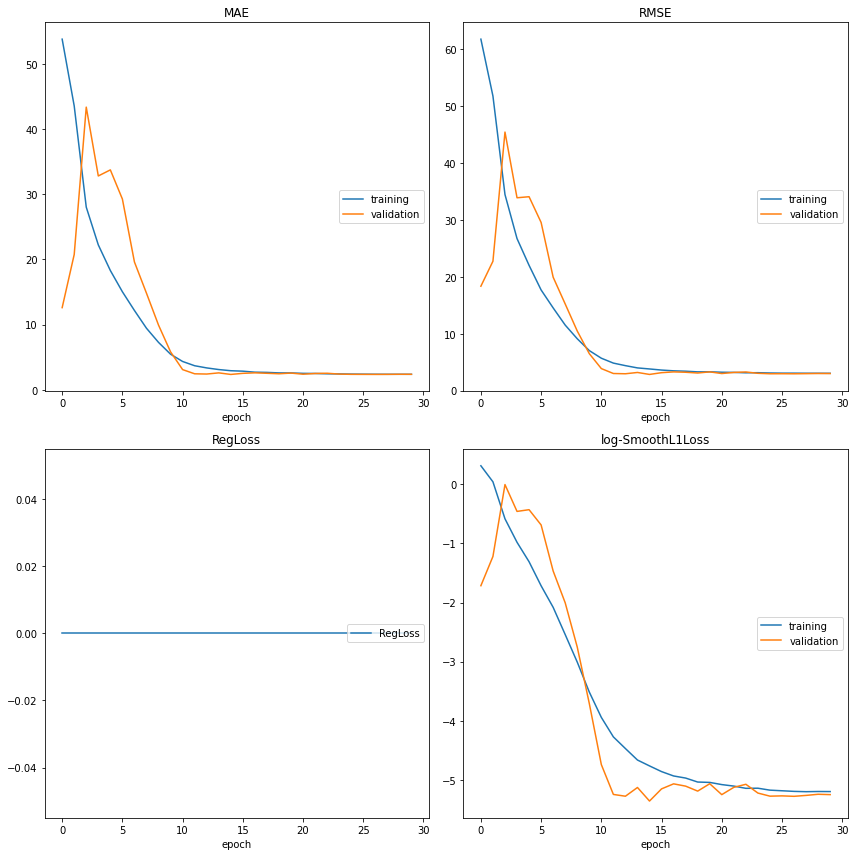

MAE
	training         	 (min:    2.380, max:   53.812, cur:    2.380)
	validation       	 (min:    2.360, max:   43.381, cur:    2.381)
RMSE
	training         	 (min:    3.050, max:   61.789, cur:    3.050)
	validation       	 (min:    2.851, max:   45.456, cur:    3.009)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -5.199, max:    0.314, cur:   -5.197)
	validation       	 (min:   -5.357, max:   -0.005, cur:   -5.249)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
25,0.005608,2.399882,3.077187,0.0,0.005143,2.368739,2.977627
26,0.005550,2.388248,3.075904,0.0,0.005106,2.362419,2.966629
27,0.005522,2.381436,3.061989,0.0,0.005185,2.370847,2.989690
28,0.005539,2.382497,3.056079,0.0,0.005285,2.385797,3.018319
29,0.005532,2.379940,3.050052,0.0,0.005254,2.380987,3.009457


In [37]:
m = NeuralProphet(n_lags = 2, num_hidden_layers =2, newer_samples_weight=4, 
                      learning_rate=0.02, epochs=30, batch_size=32, 
                      daily_seasonality=12, yearly_seasonality=6)
model = m.fit(df_train, freq= 'd', validation_df= df_val, progress= 'plot-all')
model.tail()

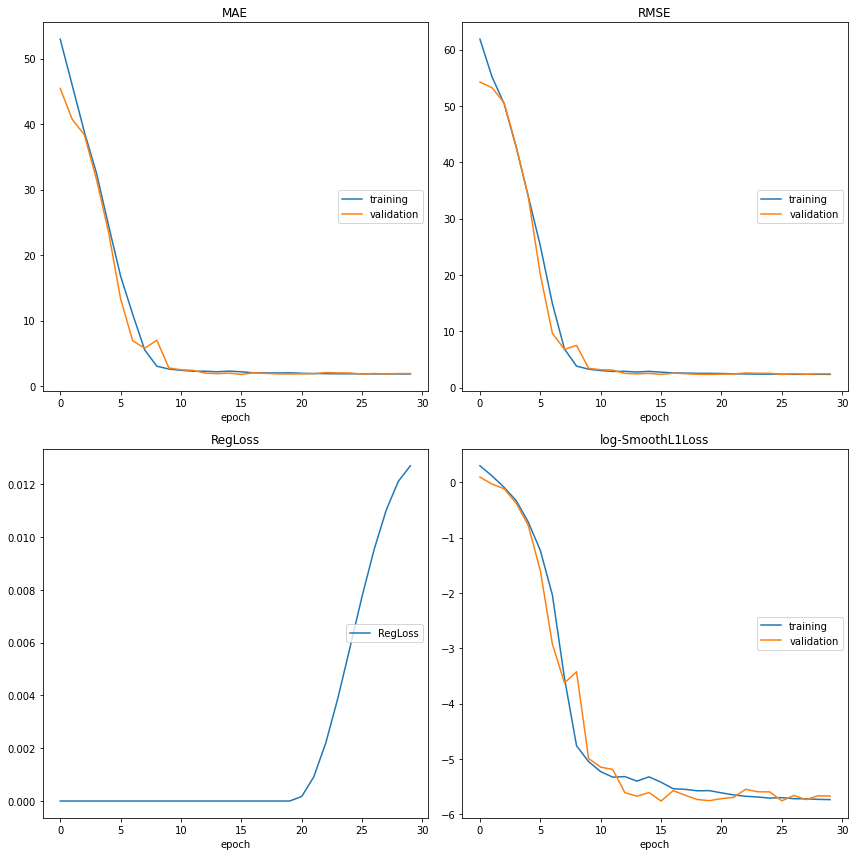

MAE
	training         	 (min:    1.860, max:   52.961, cur:    1.860)
	validation       	 (min:    1.793, max:   45.449, cur:    1.928)
RMSE
	training         	 (min:    2.336, max:   61.848, cur:    2.336)
	validation       	 (min:    2.327, max:   54.241, cur:    2.435)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.013, cur:    0.013)
log-SmoothL1Loss
	training         	 (min:   -5.738, max:    0.301, cur:   -5.738)
	validation       	 (min:   -5.763, max:    0.095, cur:   -5.672)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
25,0.003339,1.884511,2.376995,0.007756,0.003153,1.842387,2.331272
26,0.003274,1.873716,2.350585,0.009535,0.003471,1.935729,2.445916
27,0.003270,1.865318,2.348551,0.011021,0.003220,1.862634,2.356050
28,0.003235,1.862224,2.349756,0.012109,0.003453,1.931434,2.439591
29,0.003222,1.860218,2.336333,0.012698,0.003440,1.927600,2.435058


In [38]:
m = NeuralProphet(n_lags = 6, num_hidden_layers =1, newer_samples_weight=4, 
                      learning_rate=0.02, epochs=30, batch_size=32, 
                      daily_seasonality=12, yearly_seasonality=6,
                 trend_reg = 5, changepoints_range = 0.995)
model1 = m.fit(df_train, freq= 'd', validation_df= df_val, progress= 'plot-all')
model1.tail()

In [39]:
forecast = forecast.iloc[3:len(forecast)-1,:]
y = forecast['y']
ypred = forecast['yhat1']

from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score
print("\n \n Model Evaluation Report: ")
print('Mean Absolute Error(MAE) of Neural Prophet model:', mean_absolute_error(y, ypred))
print('Mean Squared Error(MSE) of Neural Prophet model:', mean_squared_error(y, ypred))
print('Root Mean Squared Error (RMSE) of Neural Prophet model:', mean_squared_error(y, ypred, squared = False))
print('Explained Variance Score (EVS) of Neural Prophet model:', explained_variance_score(y, ypred))
print('R2 of Neural Prophet model:', (r2_score(y, ypred)).round(2))


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Neural Prophet model: 1.4858997674059504
Mean Squared Error(MSE) of Neural Prophet model: 3.7391011799197478
Root Mean Squared Error (RMSE) of Neural Prophet model: 1.9336755622181678
Explained Variance Score (EVS) of Neural Prophet model: 0.9180291352119515
R2 of Neural Prophet model: 0.92


**Reference**

[Neural Prophet: Core Module Documentation](https://neuralprophet.com/html/forecaster.html)